# Tugas 4 MA4072 - Pembelajaran Mendalam
oleh:<br>
Michella Chandra - 10118011<br>
Thirafi Najwan Kurniatama - 13520157

Akan dibuat tiga model dengan arsitektur berbeda untuk memprediksi penyakit Katarak berdasarkan Fundus mata.
1. Model MLP
2. Model CNN dengan Arsitektur VGG11
3. Model RNN dengan Arsitektur LSTM

Ketiga model ini akan dilatih dan diuji menggunakan dataset Ocular Disease Recognition (ODIR) yang diperoleh dari https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k. Data yang dipertimbangkan adalah Fundus kanan atau Fundus kiri Pasien

Perlu dicatat: untuk rerun Colab ini, diperlukan kaggle API dari pengguna dan ditaruh di direktori /content/ pada runtime e.g. /content/kaggle.json. Tutorial mendapatkannya bisa mengikuti di https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

# File Download

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k

 98% 1.59G/1.62G [00:49<00:00, 32.9MB/s]
100% 1.62G/1.62G [00:49<00:00, 35.3MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip

# Setup

## Import

In [ ]:
import pandas as pd
# import cv2
# import os.path
# from google.colab.patches import cv2_imshow
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from functools import lru_cache, wraps
import torch.utils.data
import torchvision
import sklearn.metrics
from sklearn.model_selection import train_test_split
from PIL import Image

## Seed

In [ ]:
GLOBAL_SEED = 13520157+10118011
torch.manual_seed(GLOBAL_SEED)
torch.cuda.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

## Global Utilities

In [ ]:
scaler = StandardScaler()
def print_eval(cf_matrix, classes):
    fpm = np.sum(cf_matrix, axis=0)
    fnm = np.sum(cf_matrix, axis=1)
    rec = [(cf_matrix[i][i]) / (fnm[i] + 1e-10) for i in range(len(cf_matrix))]
    prec = [(cf_matrix[i][i]) / (fpm[i] + 1e-10)for i in range(len(cf_matrix))]
    f1 = [2 * prec[i] * rec[i] / (prec[i] + rec[i] + 1e-10) for i in range(len(cf_matrix))]
    raw_m = np.vstack((rec, prec, f1))
    acc = np.trace(cf_matrix) / (np.sum(cf_matrix) + 1e-10)
    print(f"\nTotal Accuracy: {acc:.4f}")
    print(pd.DataFrame(raw_m, index = ["Recall", "Precision", "F1 Score"], columns=[i for i in classes]))
def filters(row):
  try:
    Image.open(row['filepath'])
    if ("cataract" in row['Left-Diagnostic Keywords'] and "left" in row['filepath']) or ("cataract" in row['Right-Diagnostic Keywords'] and "right" in row['filepath']):
      return True
    if ("normal" in row['Left-Diagnostic Keywords'] and "left" in row['filepath']) or ("normal" in row['Right-Diagnostic Keywords'] and "right" in row['filepath']):
      return True
    return False
  except:
    return False
def labelling(row):
  if ("cataract" in row['Left-Diagnostic Keywords'] and "left" in row['filepath']) or ("cataract" in row['Right-Diagnostic Keywords'] and "right" in row['filepath']):
    return 1
  elif ("normal" in row['Left-Diagnostic Keywords'] and "left" in row['filepath']) or ("normal" in row['Right-Diagnostic Keywords'] and "right" in row['filepath']):
    return 0

## Load and Cleaning Data

In [ ]:
df = pd.read_csv("/content/full_df.csv")
df.dropna(inplace=True)
df['filepath'] = df['filepath'].str.slice_replace(start=0, stop=66, repl='/content/preprocessed_images')
df = df[['Patient Age', 'Patient Sex', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'filepath']] # REORDERING
df = df.loc[df.apply(filters, axis=1), :]
df['labels'] = df.apply(labelling, axis=1)
df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_picked = pd.concat([df.loc[df['labels'] == 0, :].sample(n=300), df.loc[df['labels'] == 1, :].sample(n=300)])
df_picked.reset_index(drop=True, inplace=True)

In [ ]:
df_picked

,Patient Age,Patient Sex,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,labels
0,25,Male,normal fundus,normal fundus,/content/preprocessed_images/2642_left.jpg,0
1,72,Male,normal fundus,normal fundus,/content/preprocessed_images/2883_left.jpg,0
2,56,Male,normal fundus,normal fundus,/content/preprocessed_images/2659_left.jpg,0
3,69,Male,normal fundus,normal fundus,/content/preprocessed_images/2513_right.jpg,0
4,63,Female,normal fundus,normal fundus,/content/preprocessed_images/2422_left.jpg,0
...,...,...,...,...,...,...
595,76,Female,cataract,normal fundus,/content/preprocessed_images/2136_left.jpg,1
596,70,Male,lens dust，cataract,cataract，lens dust,/content/preprocessed_images/2251_right.jpg,1
597,69,Male,cataract,cataract,/content/preprocessed_images/2246_left.jpg,1
598,64,Female,cataract,cataract,/content/preprocessed_images/2108_left.jpg,1


## Train and Testing Split

In [ ]:
df_train, df_test = train_test_split(df_picked, test_size=0.2, random_state=GLOBAL_SEED)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_train

,Patient Age,Patient Sex,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,labels
0,60,Female,normal fundus,normal fundus,/content/preprocessed_images/3210_left.jpg,0
1,56,Male,normal fundus,normal fundus,/content/preprocessed_images/2659_left.jpg,0
2,44,Male,normal fundus,macular epiretinal membrane,/content/preprocessed_images/140_left.jpg,0
3,51,Female,normal fundus,normal fundus,/content/preprocessed_images/3431_right.jpg,0
4,80,Female,lens dust，normal fundus,normal fundus,/content/preprocessed_images/3037_right.jpg,0
...,...,...,...,...,...,...
475,76,Male,lens dust，cataract,cataract，lens dust,/content/preprocessed_images/2244_right.jpg,1
476,56,Female,normal fundus,normal fundus,/content/preprocessed_images/2438_right.jpg,0
477,64,Male,cataract,cataract,/content/preprocessed_images/2240_right.jpg,1
478,63,Male,cataract,normal fundus,/content/preprocessed_images/2175_left.jpg,1


In [ ]:
df_test

,Patient Age,Patient Sex,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,labels
0,48,Male,normal fundus,cataract,/content/preprocessed_images/2218_right.jpg,1
1,48,Male,normal fundus,normal fundus,/content/preprocessed_images/2723_left.jpg,0
2,52,Male,normal fundus,normal fundus,/content/preprocessed_images/3050_left.jpg,0
3,54,Female,cataract,cataract,/content/preprocessed_images/2134_right.jpg,1
4,54,Female,normal fundus,epiretinal membrane,/content/preprocessed_images/60_left.jpg,0
...,...,...,...,...,...,...
115,43,Male,normal fundus,chorioretinal atrophy,/content/preprocessed_images/69_left.jpg,0
116,63,Female,lens dust，normal fundus,normal fundus，lens dust,/content/preprocessed_images/3046_right.jpg,0
117,81,Female,cataract,cataract,/content/preprocessed_images/2128_left.jpg,1
118,64,Female,normal fundus,normal fundus,/content/preprocessed_images/2944_left.jpg,0


## Dataset

In [ ]:
# Transformation
class CustomResize(object):
  def __init__(self, size):
    self.size = size
  def __call__(self, sample):
    img, imgLabel = sample['img'],  sample['labels']
    pad = torchvision.transforms.functional.resize(img, self.size)
    return {'img': pad, 'labels': imgLabel}

class CustomCenterCrop(object):
  def __init__(self, size):
    self.size = size
  def __call__(self, sample):
    img, imgLabel = sample['img'],  sample['labels']
    cr = torchvision.transforms.functional.center_crop(img, self.size)
    return {'img': cr, 'labels': imgLabel}

class RegularToNormalizedFlattenTensor(object):
  def __call__(self, sample):
    img, imgLabel = sample['img'],  sample['labels']
    timg = torchvision.transforms.functional.pil_to_tensor(img).float()
    timg = torchvision.transforms.functional.normalize(timg, mean=(0.5), std=(0.5))
    flat = torch.flatten(timg)
    return {'img': flat, 'labels': imgLabel}

class RegularToNormalizedMergedTensor(object):
  def __call__(self, sample):
    img, imgLabel = sample['img'],  sample['labels']
    timg = torchvision.transforms.functional.pil_to_tensor(img).float()
    timg = torchvision.transforms.functional.normalize(timg, mean=(0.5), std=(0.5))
    return {'img': timg, 'labels': imgLabel}

class RGBtoGS(object):
  def __call__(self, sample):
    img, imgLabel = sample['img'], sample['labels']
    gimg = torch.reshape(torchvision.transforms.functional.rgb_to_grayscale(img), (img.size(-1), img.size(-1)))
    return {'img': gimg, 'labels': imgLabel}

class EyeDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, transform=None):
    self.detail_csv = dataframe
    self.transform = transform
  def __len__(self):
    return len(self.detail_csv)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img = Image.open(self.detail_csv.iloc[idx, df.columns.get_loc('filepath')])
    imgLabel = self.detail_csv.iloc[idx, df.columns.get_loc('labels')]
    sample = {'img': img, 'labels': imgLabel}
    if self.transform:
      sample = self.transform(sample)
    return sample


# General Data Information

## General Distribution

Left Catarac: 152, Right Catarac: 148, Left Normal: 149, Right Norm: 151


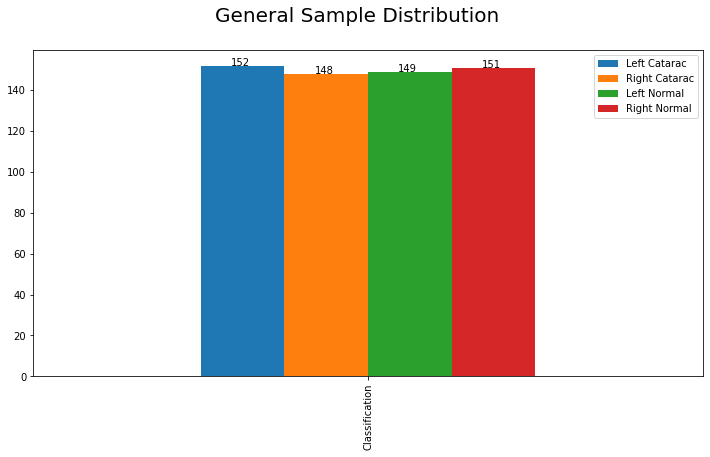

In [64]:
leftcat = len(df_picked.loc[(df_picked['Left-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("left")), :])
rightcat = len(df_picked.loc[df_picked['Right-Diagnostic Keywords'].str.contains("catarac") & ((df_picked['filepath'].str.contains("right"))), :])
leftnorm = len(df_picked.loc[df_picked['Left-Diagnostic Keywords'].str.contains("normal") & (df_picked['filepath'].str.contains("left")), :])
rightnorm = len(df_picked.loc[df_picked['Right-Diagnostic Keywords'].str.contains("normal") & (df_picked['filepath'].str.contains("right")) , :])
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('General Sample Distribution', fontsize=20)
pd.DataFrame({'Left Catarac': leftcat, 'Right Catarac': rightcat, 'Left Normal': leftnorm, 'Right Normal': rightnorm}, index=["Classification"]).plot(kind='bar', ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x()+0.045, p.get_height()))
fig.show()
print(f"Left Catarac: {leftcat}, Right Catarac: {rightcat}, Left Normal: {leftnorm}, Right Norm: {rightnorm}")

## Cataracs

### Gender

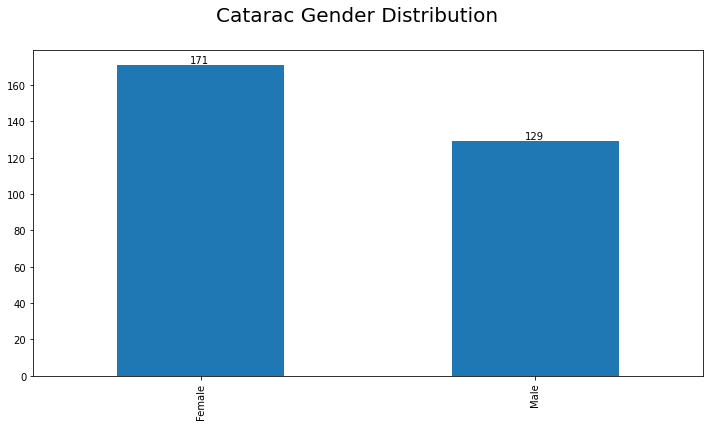

In [84]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Catarac Gender Distribution', fontsize=20)
df_picked.loc[(df_picked['Left-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("left")) | ((df_picked['Right-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("right"))), "Patient Sex"].value_counts().plot(kind="bar", ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x()+0.219, p.get_height()+1))
fig.show()

### Age

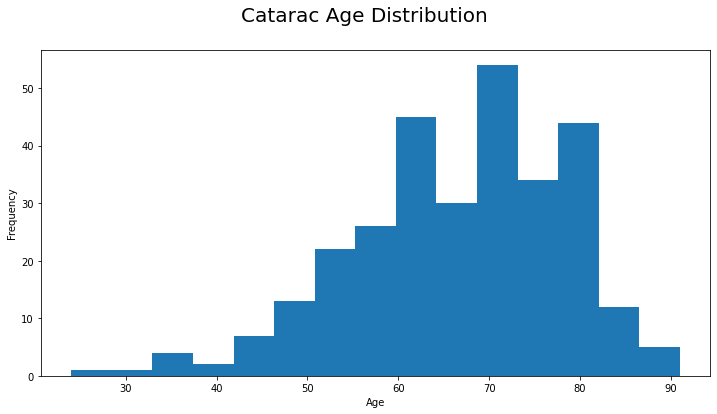

In [95]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Catarac Age Distribution', fontsize=20)
df_picked.loc[(df_picked['Left-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("left")) | ((df_picked['Right-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("right"))), "Patient Age"].plot(kind="hist", ax=ax, bins=15)
ax.set_xlabel("Age")
fig.show()

## Normal

### Gender

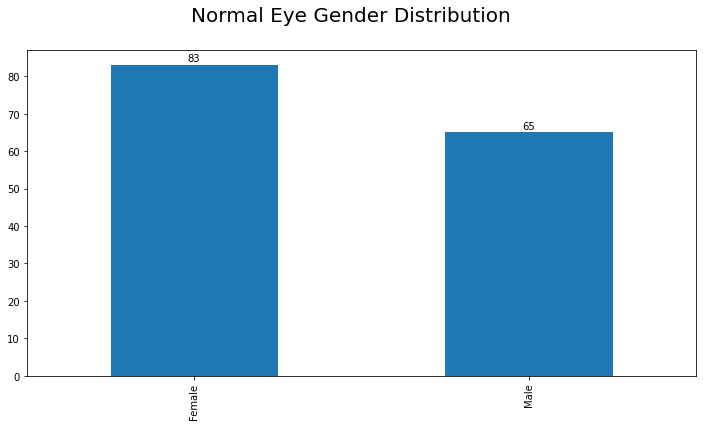

In [94]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Normal Eye Gender Distribution', fontsize=20)
df_picked.loc[(df_picked['Left-Diagnostic Keywords'].str.contains("normal")) & (df_picked['filepath'].str.contains("normal")) | ((df_picked['Right-Diagnostic Keywords'].str.contains("catarac")) & (df_picked['filepath'].str.contains("right"))), "Patient Sex"].value_counts().plot(kind="bar", ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x()+0.23, p.get_height()+1))
fig.show()

### Age

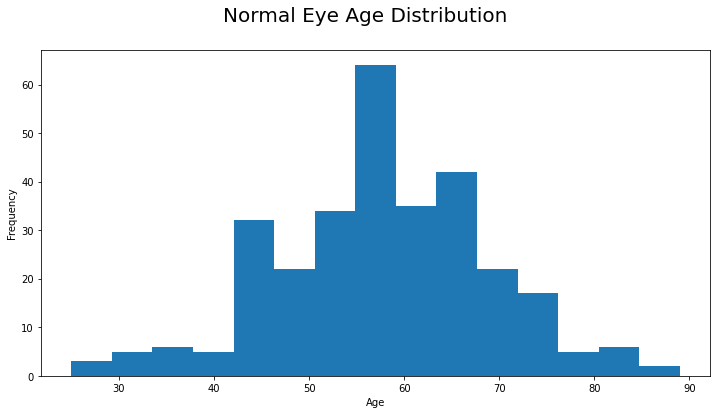

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Normal Eye Age Distribution', fontsize=20)
df_picked.loc[(df_picked['Left-Diagnostic Keywords'].str.contains("normal")) & (df_picked['filepath'].str.contains("left")) | ((df_picked['Right-Diagnostic Keywords'].str.contains("normal")) & (df_picked['filepath'].str.contains("right"))), "Patient Age"].plot(kind="hist", ax=ax, bins=15)
ax.set_xlabel("Age")
fig.show()

# Model

## MLP Approach

### MLP Model

In [ ]:
class MLPModel(torch.nn.Module):
  def __init__(self, dataframe):
    super(MLPModel, self).__init__()
    torch.manual_seed(GLOBAL_SEED)
    # DATASET LOADER
    self.dataset = EyeDataset(dataframe=dataframe,
                       transform=torchvision.transforms.Compose([
                       CustomResize(128),
                       CustomCenterCrop((128, 128)),
                       RegularToNormalizedFlattenTensor()
                     ]))
    # LAYERING
    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=1)
    self.sigmoid = torch.nn.Sigmoid()
    insize = self.dataset[0]['img'].size(dim=0)
    self.l1 = torch.nn.Linear(insize, 128)
    self.d1 = torch.nn.Dropout(p=0.25)
    self.bnorm1 = torch.nn.BatchNorm1d(128)
    self.l2 = torch.nn.Linear(128, 64)
    self.bnorm2 = torch.nn.BatchNorm1d(64)
    self.l3 = torch.nn.Linear(64, 32)
    self.bnorm3 = torch.nn.BatchNorm1d(32)
    self.lo = torch.nn.Linear(32, 1)
  def forward(self, x):
    x = self.relu(self.bnorm1(self.l1(x)))
    x = self.relu(self.bnorm2(self.l2(x)))
    x = self.relu(self.bnorm3(self.l3(x)))
    x = self.d1(x)
    x = self.lo(x)
    return x


### Training

In [ ]:
dataframe = df_train
batch_size = 32
epoch = 30
xlogger = np.array([])
ylogger = np.array([])
counter = 0


mlp_model = MLPModel(dataframe)
loader = torch.utils.data.DataLoader(mlp_model.dataset, batch_size=batch_size, num_workers=0, shuffle=True)
criterion = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.NAdam(mlp_model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3, threshold=1e-5)
if torch.cuda.is_available():
  mlp_model.to('cuda')
for e in range(epoch):
  acculoss = 0.0
  accstep = 0
  for i, batch in enumerate(loader):
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx, by = bx.to('cuda'), by.to('cuda')
      out = mlp_model.forward(bx)
      loss = criterion(out, by.unsqueeze(1).float())
      optim.zero_grad()
      loss.backward()
      optim.step()
      accstep += 1
      acculoss += loss.detach().item()
      # if ((i+1)%5 == 0):
      #     with torch.no_grad():
      #       print(f"Epoch: {e+1}; Batch: {i+1}; Loss: {loss}")
      #       xlogger = np.append(xlogger, counter)
      #       ylogger = np.append(ylogger, loss.item())
      #       counter += 1    
  print(f"Epoch: {e+1}; Loss: {acculoss/accstep}")
  xlogger = np.append(xlogger, counter)
  ylogger = np.append(ylogger, acculoss/accstep)
  counter += 1    
  sched.step(acculoss/accstep)

Epoch: 1; Loss: 0.6555738329887391
Epoch: 2; Loss: 0.6024779359499614
Epoch: 3; Loss: 0.5525592029094696
Epoch: 4; Loss: 0.4985385457674662
Epoch: 5; Loss: 0.49352105259895324
Epoch: 6; Loss: 0.4773142913977305
Epoch: 7; Loss: 0.43364712794621785
Epoch: 8; Loss: 0.4240441521008809
Epoch: 9; Loss: 0.4396765410900116
Epoch: 10; Loss: 0.38500726024309795
Epoch: 11; Loss: 0.38548091650009153
Epoch: 12; Loss: 0.36460493008295697
Epoch: 13; Loss: 0.3385884195566177
Epoch: 14; Loss: 0.33587873180707295
Epoch: 15; Loss: 0.331928159793218
Epoch: 16; Loss: 0.3082391271988551
Epoch: 17; Loss: 0.2968727469444275
Epoch: 18; Loss: 0.292848664522171
Epoch: 19; Loss: 0.3095363328854243
Epoch: 20; Loss: 0.25892120202382407
Epoch: 21; Loss: 0.29717039068539935
Epoch: 22; Loss: 0.23244941333929697
Epoch: 23; Loss: 0.22149761865536371
Epoch: 24; Loss: 0.23402495086193084
Epoch: 25; Loss: 0.19960506856441498
Epoch: 26; Loss: 0.22977172334988913
Epoch: 27; Loss: 0.23607937892278036
Epoch: 28; Loss: 0.218801

### Stats

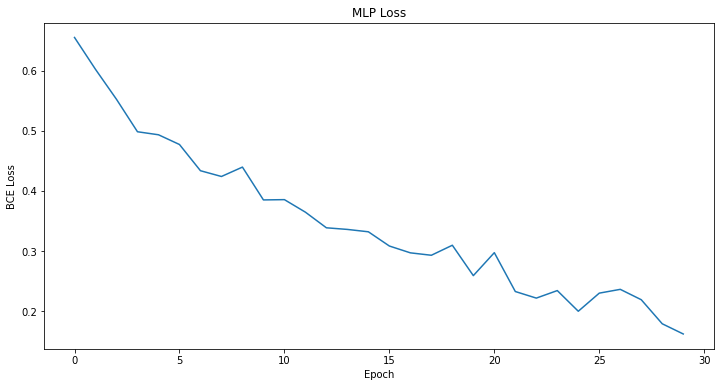

In [ ]:
# SHOW GRAPH
plt.figure(figsize=(12, 6))
plt.title(f"MLP Loss")
plt.figure(1).patch.set_facecolor("white")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.plot(xlogger, ylogger)
plt.show()

In [ ]:
test_set = EyeDataset(dataframe=df_test,
                       transform=torchvision.transforms.Compose([
                       CustomResize(128),
                       CustomCenterCrop((128, 128)),
                       RegularToNormalizedFlattenTensor()
                     ]))
loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), num_workers=0, shuffle=False)
with torch.no_grad():
  classes = ["NORMAL", "CATARACS"]
  for batch in loader:
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx = bx.to('cuda')
      out = mlp_model.forward(bx)
      outenc = torch.round(torch.flatten(torch.sigmoid(out)))
      cf_matrix = sklearn.metrics.confusion_matrix(by, outenc.cpu())
      df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
      print(df_cm)

              NORMAL (P)  CATARACS (P)
NORMAL (A)            45            12
CATARACS (A)          15            48


In [ ]:
print_eval(cf_matrix, classes)


Total Accuracy: 0.7750
             NORMAL  CATARACS
Recall     0.789474  0.761905
Precision  0.750000  0.800000
F1 Score   0.769231  0.780488


## CNN Approach (VGG)

### CNN Model

In [ ]:
# Gajadi GoogLeNet kena overfit
# class InceptionBlock(torch.nn.Module):
#   def __init__(self, in_channels, c1, c2, c3, c4):
#     super(InceptionBlock, self).__init__()
#     torch.manual_seed(GLOBAL_SEED)
#     self.relu = torch.nn.ReLU()
#     self.p1_1 = torch.nn.Conv2d(in_channels, c1, kernel_size=1)
#     self.p2_1 = torch.nn.Conv2d(in_channels, c2[0], kernel_size=1)
#     self.p2_2 = torch.nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
#     self.p3_1 = torch.nn.Conv2d(in_channels, c3[0], kernel_size=1)
#     self.p3_2 = torch.nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
#     self.p4_1 = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
#     self.p4_2 = torch.nn.Conv2d(in_channels, c4, kernel_size=1)
#   def forward(self, x):
#     p1 = torch.nn.functional.relu(self.p1_1(x))
#     p2 = self.relu(self.p2_2(self.relu(self.p2_1(x))))
#     p3 = self.relu(self.p3_2(self.relu(self.p3_1(x))))
#     p4 = self.relu(self.p4_2(self.p4_1(x)))
#     return torch.cat((p1, p2, p3, p4), dim=1)

# class CNNModel(torch.nn.Module):
#   def __init__(self, dataframe):
#     super(CNNModel, self).__init__()
#     torch.manual_seed(GLOBAL_SEED)
#     # DATASET LOADER
#     self.dataset = EyeDataset(dataframe=dataframe,
#                        transform=torchvision.transforms.Compose([
#                        CustomResize(256),
#                        CustomCenterCrop(224),
#                        RegularToNormalizedMergedTensor()
#                      ]))
#     # LAYERING
#     in_ch = self.dataset[0]['img'].size(dim=0)
#     # STAGE 1 Conv+ReLU+MaxPool
#     self.s1 = torch.nn.Sequential(torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3),
#                    torch.nn.ReLU(),
#                    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#     # STAGE 2 Double Conv+ReLU and MaxPool
#     self.s2 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=1),
#                    torch.nn.ReLU(),
#                    torch.nn.Conv2d(64, 192, kernel_size=3, padding=1),
#                    torch.nn.ReLU(),
#                    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#     # STAGE 3 Double Inception Block + MaxPool
#     self.s3 = torch.nn.Sequential(InceptionBlock(192, 64, (96, 128), (16, 32), 32),
#                    InceptionBlock(256, 128, (128, 192), (32, 96), 64),
#                    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#     # STAGE 4 Quintuple Inception Block + MaxPool
#     self.s4 = torch.nn.Sequential(InceptionBlock(480, 192, (96, 208), (16, 48), 64),
#                    InceptionBlock(512, 160, (112, 224), (24, 64), 64),
#                    InceptionBlock(512, 128, (128, 256), (24, 64), 64),
#                    InceptionBlock(512, 112, (144, 288), (32, 64), 64),
#                    InceptionBlock(528, 256, (160, 320), (32, 128), 128),
#                    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#     # STAGE 5 Double Inception Block + Adaptive Avg Pool
#     self.s5 = torch.nn.Sequential(InceptionBlock(832, 256, (160, 320), (32, 128), 128),
#                    InceptionBlock(832, 384, (192, 384), (48, 128), 128),
#                    torch.nn.AdaptiveAvgPool2d((1,1)),
#                    torch.nn.Flatten())
#     # Output Layer
#     self.lo = torch.nn.Linear(1024, 1)
#     self.d1 = torch.nn.Dropout(p=0.5)
#     # torch.nn.init.xavier_normal_(self.lo.weight)
#   def forward(self, x):
#     x = self.s5(self.s4(self.s3(self.s2(self.s1(x)))))
#     x = self.d1(x)
#     return self.lo(x)

class CNNModel(torch.nn.Module):
  def applyw(self, w):
      if type(w) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(w.weight, gain=torch.nn.init.calculate_gain('relu'))

  def __init__(self, dataframe):
    super(CNNModel, self).__init__()
    torch.manual_seed(GLOBAL_SEED)
    # DATASET LOADER
    self.dataset = EyeDataset(dataframe=dataframe,
                      transform=torchvision.transforms.Compose([
                      CustomResize(256),
                      CustomCenterCrop((224, 224)),
                      RegularToNormalizedMergedTensor()
                    ]))
    self.in_ch = self.dataset[0]['img'].size(dim=0)
    self.conv_layers = torch.nn.Sequential(
        torch.nn.Conv2d(self.in_ch, 64, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(256, 512, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Flatten()
    )
    # fully connected linear layers
    self.linear_layers = torch.nn.Sequential(
        torch.nn.Linear(512*7*7, 4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 1)
    )

  def forward(self, x):
    return self.linear_layers(self.conv_layers(x))


### Training

In [ ]:
dataframe = df_train
batch_size = 32
epoch = 30
xlogger = np.array([])
ylogger = np.array([])
counter = 0


cnn_model = CNNModel(dataframe)
loader = torch.utils.data.DataLoader(cnn_model.dataset, batch_size=batch_size, num_workers=0, shuffle=True)
criterion = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9, 
                      weight_decay=0.0005)
if torch.cuda.is_available():
  cnn_model.to('cuda')
for e in range(epoch):
  acculoss = 0.0
  accstep = 0
  for i, batch in enumerate(loader):
      optim.zero_grad()
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx, by = bx.to('cuda'), by.to('cuda')
      out = cnn_model.forward(bx)
      loss = criterion(out, by.unsqueeze(1).float())
      loss.backward()
      optim.step()
      accstep += 1
      acculoss += loss.item()
  print(f"Epoch: {e+1}; Loss: {acculoss/accstep}")
  xlogger = np.append(xlogger, counter)
  ylogger = np.append(ylogger, acculoss/accstep)
  counter += 1    

Epoch: 1; Loss: 0.6923396468162537
Epoch: 2; Loss: 0.6887384454409281
Epoch: 3; Loss: 0.6834265549977621
Epoch: 4; Loss: 0.6768775741259258
Epoch: 5; Loss: 0.6564265171686808
Epoch: 6; Loss: 0.6461218436559041
Epoch: 7; Loss: 0.650216015179952
Epoch: 8; Loss: 0.6112921953201294
Epoch: 9; Loss: 0.6624187390009563
Epoch: 10; Loss: 0.6484756151835124
Epoch: 11; Loss: 0.606783386071523
Epoch: 12; Loss: 0.5660408794879913
Epoch: 13; Loss: 0.5219585160414378
Epoch: 14; Loss: 0.5033439715703328
Epoch: 15; Loss: 0.4916908125082652
Epoch: 16; Loss: 0.4680925210316976
Epoch: 17; Loss: 0.47778066794077556
Epoch: 18; Loss: 0.4548188805580139
Epoch: 19; Loss: 0.42366792559623717
Epoch: 20; Loss: 0.4276837209860484
Epoch: 21; Loss: 0.41745562354723614
Epoch: 22; Loss: 0.4206336756547292
Epoch: 23; Loss: 0.4210062106450399
Epoch: 24; Loss: 0.3942320783933004
Epoch: 25; Loss: 0.3797900378704071
Epoch: 26; Loss: 0.3643382539351781
Epoch: 27; Loss: 0.3655871589978536
Epoch: 28; Loss: 0.3742581238349279


### Stats

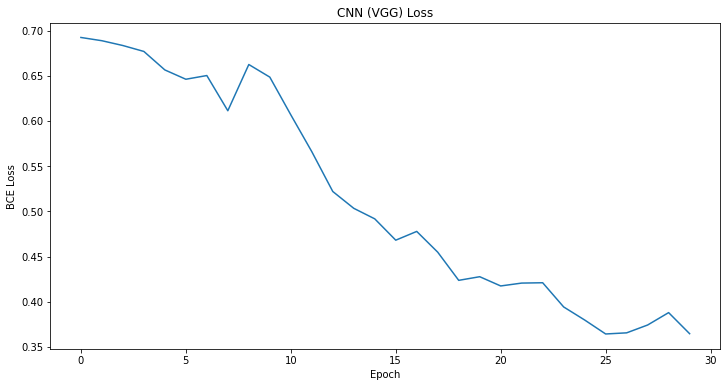

In [ ]:
# SHOW GRAPH
plt.figure(figsize=(12, 6))
plt.title(f"CNN (VGG) Loss")
plt.figure(1).patch.set_facecolor("white")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.plot(xlogger, ylogger)
plt.show()

In [ ]:
test_set =  EyeDataset(dataframe=df_test,
                       transform=torchvision.transforms.Compose([
                       CustomResize(256),
                       CustomCenterCrop((224, 224)),
                       RegularToNormalizedMergedTensor()
                     ]))
loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), num_workers=0, shuffle=False)
with torch.no_grad():
  classes = ["NORMAL", "CATARACS"]
  for batch in loader:
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx = bx.to('cuda')
      out = cnn_model.forward(bx)
      outenc = torch.round(torch.flatten(torch.sigmoid(out)))
      cf_matrix = sklearn.metrics.confusion_matrix(by, outenc.cpu())
      df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
      print(df_cm)

              NORMAL (P)  CATARACS (P)
NORMAL (A)            40            17
CATARACS (A)           5            58


In [ ]:
print_eval(cf_matrix, classes)


Total Accuracy: 0.8167
             NORMAL  CATARACS
Recall     0.701754  0.920635
Precision  0.888889  0.773333
F1 Score   0.784314  0.840580


## RNN Approach (LSTM)

### RNN Model

In [ ]:
class RNNModel(torch.nn.Module):
  def __init__(self, dataframe, input_dim, hidden_dim, layer_dim, output_dim):
    super(RNNModel, self).__init__()
    torch.manual_seed(GLOBAL_SEED)
    # DATASET LOADER
    self.dataset = EyeDataset(dataframe=dataframe,
                      transform=torchvision.transforms.Compose([
                      CustomResize(input_dim),
                      CustomCenterCrop((input_dim, input_dim)),
                      RegularToNormalizedMergedTensor()
                    ]))
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.lstmR = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
    self.lstmG = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
    self.lstmB = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
    self.fc = torch.nn.Linear(3*hidden_dim, output_dim)
    self.d1 = torch.nn.Dropout(p=0.5)

  def forward(self, x):
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    h1 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    c1 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    h2 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    c2 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
    if torch.cuda.is_available():
      h0 = h0.to('cuda')
      c0 = c0.to('cuda')
      h1 = h1.to('cuda')
      c1 = c1.to('cuda')
      h2 = h2.to('cuda')
      c2 = c2.to('cuda')

    outR, (h0n, c0n) = self.lstmR(x[:,0,:,:], (h0.detach(), c0.detach()))
    outG, (h1n, c1n) = self.lstmG(x[:,1,:,:], (h1.detach(), c1.detach()))
    outB, (h2n, c2n) = self.lstmB(x[:,2,:,:], (h2.detach(), c2.detach()))
    out = self.fc(torch.cat((outR[:, -1, :], outG[:, -1, :], outB[:, -1, :]), axis=1))
    return out

### Training

In [ ]:
dataframe = df_train
batch_size = 32
epoch = 50
xlogger = np.array([])
ylogger = np.array([])
counter = 0


rnn_model = RNNModel(dataframe, 224, batch_size, 2, 1)
loader = torch.utils.data.DataLoader(rnn_model.dataset, batch_size=batch_size, num_workers=0, shuffle=True)
criterion = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(rnn_model.parameters(), lr=0.1)
if torch.cuda.is_available():
  rnn_model.to('cuda')
for e in range(epoch):
  acculoss = 0.0
  accstep = 0
  for i, batch in enumerate(loader):
      optim.zero_grad()
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx, by = bx.to('cuda'), by.to('cuda')
      out = rnn_model.forward(bx)
      loss = criterion(out, by.unsqueeze(1).float())
      loss.backward()
      optim.step()
      accstep += 1
      acculoss += loss.item()
  print(f"Epoch: {e+1}; Loss: {acculoss/accstep}")
  xlogger = np.append(xlogger, counter)
  ylogger = np.append(ylogger, acculoss/accstep)
  counter += 1    

Epoch: 1; Loss: 0.6932337045669555
Epoch: 2; Loss: 0.6908448576927185
Epoch: 3; Loss: 0.6896891395250956
Epoch: 4; Loss: 0.6871532638867696
Epoch: 5; Loss: 0.6864095012346904
Epoch: 6; Loss: 0.685160752137502
Epoch: 7; Loss: 0.6842683315277099
Epoch: 8; Loss: 0.6826538483301798
Epoch: 9; Loss: 0.679977027575175
Epoch: 10; Loss: 0.6783825914065044
Epoch: 11; Loss: 0.677316443125407
Epoch: 12; Loss: 0.6744725545247395
Epoch: 13; Loss: 0.673015566666921
Epoch: 14; Loss: 0.668613851070404
Epoch: 15; Loss: 0.6695548733075459
Epoch: 16; Loss: 0.6652405222256979
Epoch: 17; Loss: 0.6647122939427693
Epoch: 18; Loss: 0.6646215558052063
Epoch: 19; Loss: 0.6630696495374043
Epoch: 20; Loss: 0.660612940788269
Epoch: 21; Loss: 0.6653397719065348
Epoch: 22; Loss: 0.6628859996795654
Epoch: 23; Loss: 0.6568632404009501
Epoch: 24; Loss: 0.6536799470583597
Epoch: 25; Loss: 0.6525469064712525
Epoch: 26; Loss: 0.6562415719032287
Epoch: 27; Loss: 0.6526901523272196
Epoch: 28; Loss: 0.6513897538185119
Epoch: 

### Stats

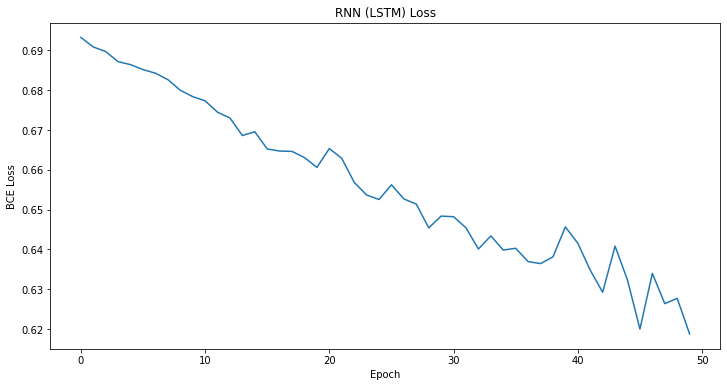

In [ ]:
# SHOW GRAPH
plt.figure(figsize=(12, 6))
plt.title(f"RNN (LSTM) Loss")
plt.figure(1).patch.set_facecolor("white")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.plot(xlogger, ylogger)
plt.show()

In [ ]:
test_set =  EyeDataset(dataframe=df_test,
                       transform=torchvision.transforms.Compose([
                       CustomResize(224),
                       CustomCenterCrop((224, 224)),
                       RegularToNormalizedMergedTensor()
                     ]))
loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), num_workers=0, shuffle=False)
with torch.no_grad():
  classes = ["NORMAL", "CATARACS"]
  for batch in loader:
      bx, by = batch['img'], batch['labels']
      if torch.cuda.is_available():
        bx = bx.to('cuda')
      out = rnn_model.forward(bx)
      outenc = torch.round(torch.flatten(torch.sigmoid(out)))
      cf_matrix = sklearn.metrics.confusion_matrix(by, outenc.cpu())
      df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
      print(df_cm)

              NORMAL (P)  CATARACS (P)
NORMAL (A)            23            34
CATARACS (A)          27            36


In [ ]:
print_eval(cf_matrix, classes)


Total Accuracy: 0.4917
             NORMAL  CATARACS
Recall     0.403509  0.571429
Precision  0.460000  0.514286
F1 Score   0.429907  0.541353
